In [41]:
# Questions
# Do we do HWE check on gangstr? check chr21:8993159
# Compute MI rate per locus, can filter on that?
# check low MI rate trios
# check sample whose trio we said was missing

In [17]:
%pylab inline

import pandas as pd
data = pd.read_csv("results/mend_chr21.tab", sep="\t", 
                   names=["chrom","pos","motif","sample","method","gbs","MI","gtscore","alscore"])

Populating the interactive namespace from numpy and matplotlib


[0.9351826649195323, 0.9394380320277752, 0.9403463416308632, 0.9405469488679966, 0.9406207141591914]
[0.9678357853540336, 0.9692984527561884, 0.9695377966180746, 0.9696256173464172, 0.969677096799836]
[0.9804868235767451, 0.9806221623767846, 0.9806770404403797, 0.9807250912884715, 0.9807228705951977]
[0.9742521743117863, 0.9740960200560737, 0.9740727170844199, 0.974026606363238, 0.974031985620547]
[0.9682767632465861, 0.9695807627593943, 0.9695549192208435, 0.9694995305431473, 0.9695092867465419]
[0.962820785441685, 0.9626272098919801, 0.9626091291695169, 0.962601211052595, 0.9625999095159101]
[0.9027050802727072, 0.9037707798351129, 0.9016576124808469, 0.9017354487507561, 0.9017636930522593]
[0.9351826649195323, 0.9351867748101322, 0.9351922995194958, 0.9393911344518442, 0.9405729628149213]
[0.9677397519361325, 0.9678943229815902, 0.9679779990205318, 0.9693114141372654, 0.9696480074268399]
[0.9804591922238981, 0.9804575546802984, 0.9804732041049031, 0.9806246709646238, 0.9807255940116

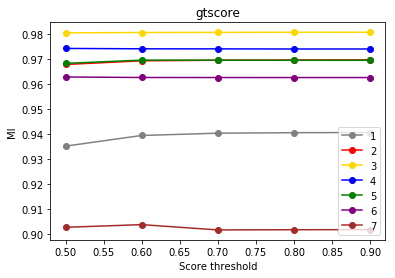

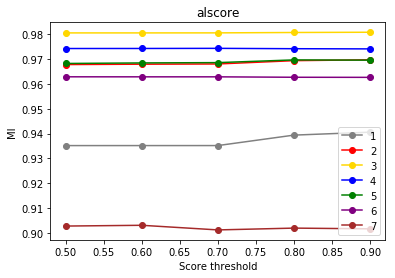

In [2]:
# MI vs. gtscore by period
percolors = ["gray","red","gold","blue","green","purple","brown"]

def PlotByScore(data, scorecol, percolors):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for period in range(1, 8):
        if period < 7:
            pdata = data[data["motif"].apply(len)==period].copy()
        else: pdata = data[data["motif"].apply(len)>=period].copy()
        mis = []
        ns = []
        thresh = np.arange(0.5, 1.0, 0.1)
        for t in thresh:
            mis.append(np.mean(pdata[pdata[scorecol]>=t]["MI"]))
            ns.append(pdata[pdata[scorecol]>=t].shape[0])
        ax.plot(thresh, mis, marker="o", color=percolors[period-1], label=period)
        print(mis)
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("MI")
    ax.set_title(scorecol)
    ax.legend(loc="lower right")
    
PlotByScore(data, "gtscore", percolors)
PlotByScore(data, "alscore", percolors)

In [3]:
# by method (advntr|eh|hipstr|gangstr)
data.groupby(["method"], as_index=False).agg({"MI": np.mean, "sample": len}).sort_values(["MI"], ascending=False)

,method,MI,sample
5,0|1|1|0,0.990379,64338
6,0|1|1|1,0.988127,129542
3,0|1|0|0,0.983026,26983
4,0|1|0|1,0.982184,10440
10,1|1|0|1,0.976705,601
1,0|0|1|0,0.976560,1566877
2,0|0|1|1,0.937273,2494635
8,1|0|0|1,0.895623,1188
0,0|0|0|1,0.887043,449126
7,1|0|0|0,0.867719,4876


,sample,MI,pos
276,HG02683,0.925984,7674
152,HG01683,0.934666,7653
462,NA10843,0.934785,7575
293,HG02776,0.935703,7652
106,HG01367,0.935980,8060


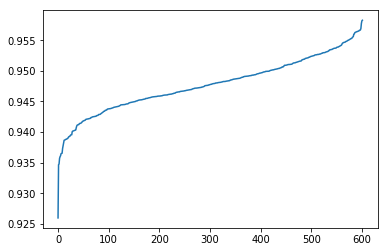

In [18]:
# by sample. check by ancestry
bysample = data.groupby("sample", as_index=False).agg({"MI": np.mean, "pos": len}).sort_values("MI")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(bysample.shape[0]), bysample["MI"])
bysample.head()

In [38]:
# (advntr|eh|hipstr|gangstr)
bypos = data.groupby(["method","pos"], as_index=False).agg({"MI": np.mean, "sample": len})

In [44]:
# Bad gangstr-only calls
bypos[(bypos["method"]=="0|0|0|1") & (bypos["sample"]>10)].sort_values(["MI","sample"])

,method,pos,MI,sample
16351,1|0|0|0,44647018,0.555340,515
16332,1|0|0|0,41168061,0.581395,43
16324,1|0|0|0,31671896,0.585366,41
16327,1|0|0|0,33229807,0.608696,46
16341,1|0|0|0,42863365,0.627119,59
16359,1|0|0|0,45288164,0.645161,62
16344,1|0|0|0,43719167,0.650794,63
16349,1|0|0|0,44558163,0.738220,382
16354,1|0|0|0,44697650,0.768025,319
16322,1|0|0|0,30635322,0.829268,41


In [45]:
# Bad advntr-only calls
bypos[(bypos["method"]=="1|0|0|0") & (bypos["sample"]>10)].sort_values(["MI","sample"])

,method,pos,MI,sample
16351,1|0|0|0,44647018,0.555340,515
16332,1|0|0|0,41168061,0.581395,43
16324,1|0|0|0,31671896,0.585366,41
16327,1|0|0|0,33229807,0.608696,46
16341,1|0|0|0,42863365,0.627119,59
16359,1|0|0|0,45288164,0.645161,62
16344,1|0|0|0,43719167,0.650794,63
16349,1|0|0|0,44558163,0.738220,382
16354,1|0|0|0,44697650,0.768025,319
16322,1|0|0|0,30635322,0.829268,41
